# VAJA: Programski dostop do UniProt (Python)

Tudi ta vaja, podobno kot prejšnje, delno temelji na uporabi [BioPythona](https://biopython.org), a le v delu, ki se nanaša na analizo zaporedja. Do zbirke sáme ne dostopamo prek E-utilities (le-te so za strežnik NCBI), ampak kar direktno iz Pythona z uporabo posebnega modula `requests`, ki omogoča dostop do storitev prek HTTP. Načeloma bi lahko podoben dostop uporabili tudi za Entrez, a bi morali naslove ustrezno prilagoditi.

Najprej si oglejte in preizkusite delovanje delov kode v spodnjih razdelkih, nato pa rešite nalogo na dnu tega zvezka - z ustrezno kombinacijo nekaterih delov kode iz zgledov ter prilagoditvijo kode, da bo rezultat tak, kot je navedeno.

---
## Ozadje
Osnovna navodila za t.i. programatski dostop do zbirke [UniProt](https://www.uniprot.org) so na voljo na podstrani [Programmatic access](https://www.uniprot.org/help/programmatic_access), kjer je opisan dostop preko **REST**.

Kaj je REST? REST ali *REpresentational State Transfer* podaja smernice pri razvoju spletnih storitev z namenom omogočanja in olajšanja interoperabilnosti med sistemi na spletu. Spletne storitve, ki so v skladu s temi smernicami, se imenujejo RESTful spletne storitve ter omogočajo dostop preko uniformnega in definiranega seta operacij. Več o tem lahko preberete na [Wikipediji](https://en.wikipedia.org/wiki/Representational_state_transfer), razloženo pa je tudi v videoposnetku spodaj (in še mimogrede vidimo primer, kako v zvezek JupyterLab vključumo video z YouTube).

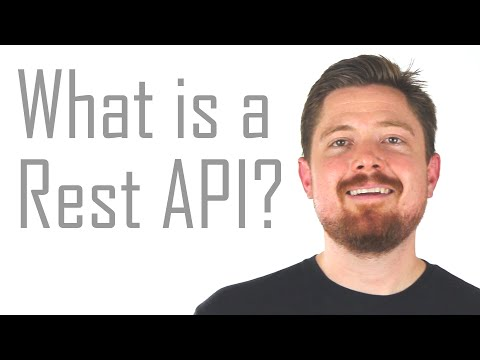

In [1]:
from IPython.display import YouTubeVideo
id='7YcW25PHnAA'
YouTubeVideo(id=id,width=600,height=300)

---
## Zgledi

### Definiranje naslovov
Najprej vključimo modul _requests_, ki nam omogoča dostop do storitev preko protokola HTTP.

In [2]:
import requests

Definiramo spletni naslov storitve in dodatne parametre (torej, kje se kaj nahaja).

In [3]:
BASE = 'http://www.uniprot.org'
KB_ENDPOINT = '/uniprot/'
TOOL_ENDPOINT = '/uploadlists/'

Zakaj je tako? Zato, ker lahko do posameznih zapisov v zbirki lahko dostopamo direktno preko naslova, če le poznamo kodo zapisa v zbirko (*accession code*). Na primer, do zapisa s kodo P59595 lahko direktno dostopamo preko spleta na naslovu https://www.uniprot.org/uniprot/P59595. Druge oblike zapisa so dostopne preko naslednjih naslovov (podanih je nekaj primerov, ostale si lahko ogledate [tukaj](https://www.uniprot.org/help/api%5Fretrieve%5Fentries)) - pri vseh vidite enoten vzorec zapisa:
* tekstna datoteka: https://www.uniprot.org/uniprot/P59595.txt
* zapis v formatu XML: https://www.uniprot.org/uniprot/P59595.xml
* zaporedje v formatu FASTA: https://www.uniprot.org/uniprot/P59595.fasta

### Iskanje po UniProtu
Če iščemo po UniProtu preko spletnega vmesnika (*Advanced search*, na primer s pojmoma *matriptase* kot ime proteina (*name*) ter *homo sapiens* kot organizem ter želimo samo ročno pregledane (*reviewed*) zapise, to izgleda v iskalnem polju tako: `(protein_name:matriptase) AND (organism_name:"homo sapiens") AND (reviewed:true)`. Ko sprožimo iskanje pa izgleda URL v naslovni vrsti v brskalniku tako: `https://www.uniprot.org/uniprotkb?query=%28protein_name%3Amatriptase%29%20AND%20%28organism_name%3A%22homo%20sapiens%22%29%20AND%20%28reviewed%3Atrue%29`. Imena posameznih polj (*return fields*) so na voljo v [dokumentaciji](https://www.uniprot.org/help/return_fields).

Tak strukturiran zapis lahko uporabimo v Pythonu, pri čemer nastavimo kot tip izpisa seznam (*list*; glejte na konec URL), da dobimo samo seznam kod zapisov, hkrati pa lahko nastavimo, da nam program vrne ime napake, če gre kaj narobe (kode napak in njihovi opisi so [dokumentirani](https://www.uniprot.org/help/api%5Fretrieve%5Fentries)). Da zadeva deluje moramo wgolj *www* nadomestiti z *rest* ter pred *query* vstaviti */search*, kot je opisano [tukaj](https://www.uniprot.org/help/api_queries).  Torej:

In [4]:
import requests
fullURL = ("https://rest.uniprot.org/uniprotkb/search?query=%28protein_name%3Amatriptase%29%20AND%20%28organism_name%3A%22homo%20sapiens%22%29%20AND%20%28reviewed%3Atrue%29&format=list")
result = requests.get(fullURL)
if result.ok:
    print(result.text)
else:
    print("Nekaj je šlo narobe ", result.status_code)

Q8IU80
Q9Y5Y6
Q7RTY8



*Morda en majhen komentar: strežnik Uniprot bo zaznal, če boste v zelo kratkih časovnih razmikih poslali isto povpraševanje in bo rezultate drugega, tretjega ... povpraševanja vrnil z daljšim zamikom. Namen tega je preprečiti, da bi ljudje zasičili strežnik z poizvedbami z istega naslova IP. Velja torej podobno, kot smo videli pri uporabo NCBI E-utilities.*

Elegantnejši način brez direktne uporabe spletnega naslova je s t.i. *payload*, kjer iskalne pojme določimo posebej. Njihov seznam z opisom, kaj je kaj, najdete na spletnih straneh:
* besedilno iskanje po Uniprot - [Text search](https://www.uniprot.org/help/text-search)
* iskalna polja - [UniProtKB query fields](https://www.uniprot.org/help/query-fields)

In [5]:
BASE = "https://rest.uniprot.org"
KB_ENDPOINT = "/uniprotkb/search"
TOOL_ENDPOINT = "/uploadlists/"
payload = {'query': 'protein_name:matriptase AND organism_name:"homo sapiens" AND reviewed:true',
           'format': 'list'}
result = requests.get(BASE + KB_ENDPOINT, params=payload)
if result.ok:
    print(result.text)
else:
    print('Nekaj je šlo narobe: ', result.status_code)

Q8IU80
Q9Y5Y6
Q7RTY8



Če je nek iskalni pojem sestavljen iz večih besed (npr. *homo sapiens*), ga moramo dati v narekovaje.

### Izpis zaporedja
V kakšnem formatu želimo izpis določimo preko spremenljivke *format*, ki lahko zavzame možnosti html, tab, xls, fasta, txt itd., kar je [dokumentirano v opisu API](https://www.uniprot.org/help/api%5Fqueries). Recimo, če si želimo izpis vseh rezultatov v formatu FASTA in izpis omejimo na prvih 300 znakov, naredimo tako:

In [6]:
payload2 = {'query': 'protein_name:matriptase AND organism_name:"homo sapiens" AND reviewed:true',
           'format': 'fasta'}

result2 = requests.get(BASE + KB_ENDPOINT, params=payload2)

if result2.ok:
    print(result2.text[:300])
else:
    print('Nekaj je šlo narobe  ', result2.status_code)

>sp|Q8IU80|TMPS6_HUMAN Transmembrane protease serine 6 OS=Homo sapiens OX=9606 GN=TMPRSS6 PE=1 SV=3
MLLLFHSKRMPVAEAPQVAGGQGDGGDGEEAEPEGMFKACEDSKRKARGYLRLVPLFVLL
ALLVLASAGVLLWYFLGYKAEVMVSQVYSGSLRVLNRHFSQDLTRRESSAFRSETAKAQK
MLKELITSTRLGTYYNSSSVYSFGEGPLTCFFWFILQIPEHRRLMLSPEVVQALLVEELL
STVNSSAAVPYRAEYEV


Ta način lahko uporabimo tudi za dostop do točno določenega zapisa tako, da podamo kodo zapisa:

In [7]:
payload3 = {'query': 'accession:Q7RTY8', 'format': 'fasta'}
result3 = requests.get(BASE + KB_ENDPOINT, params=payload3)
if result3.ok:
    print(result3.text)
else:
    print('Nekaj je šlo narobe: ', result3.status_code)

>sp|Q7RTY8|TMPS7_HUMAN Transmembrane protease serine 7 OS=Homo sapiens OX=9606 GN=TMPRSS7 PE=2 SV=3
MDKENSDVSAAPADLKISNISVQVVSAQKKLPVRRPPLPGRRLPLPGRRPPQRPIGKAKP
KKQSKKKVPFWNVQNKIILFTVFLFILAVIAWTLLWLYISKTESKDAFYFAGMFRITNIE
FLPEYRQKESREFLSVSRTVQQVINLVYTTSAFSKFYEQSVVADVSSNNKGGLLVHFWIV
FVMPRAKGHIFCEDCVAAILKDSIQTSIINRTSVGSLQGLAVDMDSVVLNAGLRSDYSST
IGSDKGCSQYFYAEHLSLHYPLEISAASGRLMCHFKLVAIVGYLIRLSIKSIQIEADNCV
TDSLTIYDSLLPIRSSILYRICEPTRTLMSFVSTNNLMLVTFKSPHIRRLSGIRAYFEVI
PEQKCENTVLVKDITGFEGKISSPYYPSYYPPKCKCTWKFQTSLSTLGIALKFYNYSITK
KSMKGCEHGWWEINEHMYCGSYMDHQTIFRVPSPLVHIQLQCSSRLSDKPLLAEYGSYNI
SQPCPVGSFRCSSGLCVPQAQRCDGVNDCFDESDELFCVSPQPACNTSSFRQHGPLICDG
FRDCENGRDEQNCTQSIPCNNRTFKCGNDICFRKQNAKCDGTVDCPDGSDEEGCTCSRSS
SALHRIIGGTDTLEGGWPWQVSLHFVGSAYCGASVISREWLLSAAHCFHGNRLSDPTPWT
AHLGMYVQGNAKFVSPVRRIVVHEYYNSQTFDYDIALLQLSIAWPETLKQLIQPICIPPT
GQRVRSGEKCWVTGWGRRHEADNKGSLVLQQAEVELIDQTLCVSTYGIITSRMLCAGIMS
GKRDACKGDSGGPLSCRRKSDGKWILTGIVSWGHGSGRPNFPGVYTRVSNFVPWIHKYVP
SLL



Če gremo na Uniprot in pogledamo zapis za ta protein vidimo, da je v Uniprot dokumentiranih več zaporedij, ki ustrezajo izooblikam (*isoforms*): [https://www.uniprot.org/uniprot/Q7RTY8#sequences](https://www.uniprot.org/uniprot/Q7RTY8#sequences).

Kako vidimo vse? Dodamo ```include```:

In [8]:
payload4 = {'query': 'accession:Q7RTY8', 'format': 'fasta',
            # spodnja vrstica omogoča vključitev izooblik v izpis
            'include' : 'yes'}
result4 = requests.get(BASE + KB_ENDPOINT, params=payload4)
if result4.ok:
    print(result4.text)
else:
    print('Nekaj je šlo narobe: ', result4.status_code)

>sp|Q7RTY8|TMPS7_HUMAN Transmembrane protease serine 7 OS=Homo sapiens OX=9606 GN=TMPRSS7 PE=2 SV=3
MDKENSDVSAAPADLKISNISVQVVSAQKKLPVRRPPLPGRRLPLPGRRPPQRPIGKAKP
KKQSKKKVPFWNVQNKIILFTVFLFILAVIAWTLLWLYISKTESKDAFYFAGMFRITNIE
FLPEYRQKESREFLSVSRTVQQVINLVYTTSAFSKFYEQSVVADVSSNNKGGLLVHFWIV
FVMPRAKGHIFCEDCVAAILKDSIQTSIINRTSVGSLQGLAVDMDSVVLNAGLRSDYSST
IGSDKGCSQYFYAEHLSLHYPLEISAASGRLMCHFKLVAIVGYLIRLSIKSIQIEADNCV
TDSLTIYDSLLPIRSSILYRICEPTRTLMSFVSTNNLMLVTFKSPHIRRLSGIRAYFEVI
PEQKCENTVLVKDITGFEGKISSPYYPSYYPPKCKCTWKFQTSLSTLGIALKFYNYSITK
KSMKGCEHGWWEINEHMYCGSYMDHQTIFRVPSPLVHIQLQCSSRLSDKPLLAEYGSYNI
SQPCPVGSFRCSSGLCVPQAQRCDGVNDCFDESDELFCVSPQPACNTSSFRQHGPLICDG
FRDCENGRDEQNCTQSIPCNNRTFKCGNDICFRKQNAKCDGTVDCPDGSDEEGCTCSRSS
SALHRIIGGTDTLEGGWPWQVSLHFVGSAYCGASVISREWLLSAAHCFHGNRLSDPTPWT
AHLGMYVQGNAKFVSPVRRIVVHEYYNSQTFDYDIALLQLSIAWPETLKQLIQPICIPPT
GQRVRSGEKCWVTGWGRRHEADNKGSLVLQQAEVELIDQTLCVSTYGIITSRMLCAGIMS
GKRDACKGDSGGPLSCRRKSDGKWILTGIVSWGHGSGRPNFPGVYTRVSNFVPWIHKYVP
SLL



### Napake pri iskanju
Včasih se zatipkamo v imenu ali kodi dostopa. Kaj se zgodi v primeru, da UniProt ne najde ničesar (v spodnjem primeru je v *accession code* iz zgornjega primera dodan še znak *x*? Nekaj možnosti:
* code 200: poizvedba uspešno opravljena
* code 400: nekaj je narobe s poizvedbo, preverite formulacijo iskanja

In [9]:
payload5 = {'query': 'accession:Q7RTY8x', 'format': 'list'}
result5 = requests.get(BASE + KB_ENDPOINT, params=payload5)
if result5.ok:
    print('Prejet odgovor strežnika, code {}'.format(result5.status_code))
    print(result5.text)
else:
    print('Nekaj je šlo narobe: ', result5.status_code)

Nekaj je šlo narobe:  400


### Izvoz v datoteko
Pa naredimo sedaj še nekaj drugega - rezultat (lahko bi jih bilo več) shranimo v lokalno datoteko, nato za test izpišemo njeno vsebino ter jo pretvorimo v objekt Seq:

In [10]:
payload6 = {'query': 'accession:Q7RTY8', 'format': 'fasta'}
result6 = requests.get(BASE + KB_ENDPOINT, params=payload6)
# print(result6.text)

f = open('izhod/uniprot-sample_output.fasta', 'w')
f.write(result6.text)
f.close()

# odpremo in preberemo datoteko
f = open('izhod/uniprot-sample_output.fasta', 'r')
print(f.read())

# izpišemo vsebino prebrane datoteke z uporabo BioPythona
from Bio import SeqIO
for seq_record in SeqIO.parse('izhod/uniprot-sample_output.fasta', 'fasta'):
    print(seq_record.id)   # izpišemo ID
    print(repr(seq_record.seq))   # izpišemo objekt
    print(seq_record.seq)   # izpišemo samo zaporedje
    print(len(seq_record))   # izpišemo dolžino zaporedja

>sp|Q7RTY8|TMPS7_HUMAN Transmembrane protease serine 7 OS=Homo sapiens OX=9606 GN=TMPRSS7 PE=2 SV=3
MDKENSDVSAAPADLKISNISVQVVSAQKKLPVRRPPLPGRRLPLPGRRPPQRPIGKAKP
KKQSKKKVPFWNVQNKIILFTVFLFILAVIAWTLLWLYISKTESKDAFYFAGMFRITNIE
FLPEYRQKESREFLSVSRTVQQVINLVYTTSAFSKFYEQSVVADVSSNNKGGLLVHFWIV
FVMPRAKGHIFCEDCVAAILKDSIQTSIINRTSVGSLQGLAVDMDSVVLNAGLRSDYSST
IGSDKGCSQYFYAEHLSLHYPLEISAASGRLMCHFKLVAIVGYLIRLSIKSIQIEADNCV
TDSLTIYDSLLPIRSSILYRICEPTRTLMSFVSTNNLMLVTFKSPHIRRLSGIRAYFEVI
PEQKCENTVLVKDITGFEGKISSPYYPSYYPPKCKCTWKFQTSLSTLGIALKFYNYSITK
KSMKGCEHGWWEINEHMYCGSYMDHQTIFRVPSPLVHIQLQCSSRLSDKPLLAEYGSYNI
SQPCPVGSFRCSSGLCVPQAQRCDGVNDCFDESDELFCVSPQPACNTSSFRQHGPLICDG
FRDCENGRDEQNCTQSIPCNNRTFKCGNDICFRKQNAKCDGTVDCPDGSDEEGCTCSRSS
SALHRIIGGTDTLEGGWPWQVSLHFVGSAYCGASVISREWLLSAAHCFHGNRLSDPTPWT
AHLGMYVQGNAKFVSPVRRIVVHEYYNSQTFDYDIALLQLSIAWPETLKQLIQPICIPPT
GQRVRSGEKCWVTGWGRRHEADNKGSLVLQQAEVELIDQTLCVSTYGIITSRMLCAGIMS
GKRDACKGDSGGPLSCRRKSDGKWILTGIVSWGHGSGRPNFPGVYTRVSNFVPWIHKYVP
SLL

sp|Q7RTY8|TMPS7_HUMAN
Seq('MDKENSDVSAAPAD

### Drugi servisi

Dostop do zbirk zaporedij je mogoč tudi preko drugih servisovm, na primer EMBL/EBI, kjer na voljo obširna navodila za dostop na strani [Job Dispatcher Sequence Analysis Tools Home](https://www.ebi.ac.uk/seqdb/confluence/display/JDSAT/Job+Dispatcher+Sequence+Analysis+Tools+Home). Vsebina zbirke je enaka kot na UniProt.

---
## Izračun nekaterih osnovnih parametrov aminokislinskega zaporedja

Za aminokislinsko zaporedje od zgoraj lahko s pomočjo *ProteinAnalysis*, ki je del modula [ProtParam](https://biopython.org/wiki/ProtParam) v BioPython, izračunamo nekatere osnovne parametre. Pri tem moramo biti pozorni, da objekt Seq pretvorimo v niz oz. *string*.

Kaj vse modul ProtParam omogoča si oglejte na spletni strani [BioPython ProtParam](https://biopython.org/wiki/ProtParam).

In [11]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
sequence = str(seq_record.seq)
analysis_seq = ProteinAnalysis(sequence)
print('Molekulska masa [Da]: %0.2f' % analysis_seq.molecular_weight())

# število alaninskih ostankov
print('Število A:', analysis_seq.count_amino_acids()['A'])

# delež ostankov, ki jih predstavljajo alaninski ostanki
print('Delež  A: %0.2f' % analysis_seq.get_amino_acids_percent()['A'])

# izoelektrična točka
print('Izoelektrična točka (pI): %0.2f' % analysis_seq.isoelectric_point())

# delež ak-ostankov, ki so preferenčno v določenem elementu sekundarne strukture [helix, turn, sheet]
sec_struc = analysis_seq.secondary_structure_fraction()
print('Delež alfa-vijačnic: %0.2f' % sec_struc[0])

# ekstinkcijski koeficient
excoeff_prot = analysis_seq.molar_extinction_coefficient()
# ekstinkcijski koeficient, vsi cisteinski ostanki reducirani (prosti)
print("Molarni ekstinkcijski koeficient, red. [1/(M cm)]:", excoeff_prot[0])
# ekstinkcijski koeficient, vsi cisteinski ostanki v obliki cistinov
print("Molarni ekstinkcijski koeficient, oks. [1/(M cm)]:", excoeff_prot[1])

Molekulska masa [Da]: 94413.49
Število A: 40
Delež  A: 0.05
Izoelektrična točka (pI): 8.84
Delež alfa-vijačnic: 0.32
Molarni ekstinkcijski koeficient, red. [1/(M cm)]: 139690
Molarni ekstinkcijski koeficient, oks. [1/(M cm)]: 141940


Gre za podobno analizo, ki jo izvede spletna storitev ProtParam na naslovu https://web.expasy.org/protparam/.

---
## Analiza zaporedja z drsečim oknom

Za primer bomo analizirali hidrofobnost proteina in sicer bomo narisali hidrofobni profil. Pri tovrstnih analizah ponavadi uporabljamo drseče okno ustrezne velikosti, pri čemer nek parameter povprečimo po tem oknu in ga pripišemo aminokislinskemu ostanki v sredini tega okna. Zato, da je določitev ak-ostanka v sredini okna nedvoumna, uporabljamo kot velikost okna liho število ak-ostankov.

O analizi z uporabo drsečega okna smo že govorili na predavanjih:
![Analiza z drsečim oknom](slike/drsece_okno.png)

Definirajmo aminokislinsko zaporedje, ki ga bomo uporabili za analizo:

In [12]:
from Bio import SeqIO
seq_record = SeqIO.read('vhod/tetraspanin1.fasta', 'fasta')
print(seq_record.id)

sp|O60635|TSN1_HUMAN


Kot lestvico hidrofobnosti bomo vzeli Kyte-Doolittle lestvico, ki je pripravljena v datoteki formata _comma separated values_ (csv; [Wikipedia](https://en.wikipedia.org/wiki/Comma-separated_values)): [hphob_scales.csv](vhod/hphob_scales.csv). Datoteka sicer vsebuje naslednje lestvice hidrofobnosti:
* KD - Kyte & Doolittle
* HW - Hopp & Woods
* Co - Cohen
* Ei - Eisenberg
* Ro - Rose
* Ja - Janin
* En - Engelman

Več o lestvicah hidrofobnosti lahko preberete v članku [50 years of amino acid hydrophobicity scales: revisiting the capacity for peptide classification](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4932767/).

Za delo s podatki v obliki tabel bomo uporabili [pandas](https://pandas.pydata.org), paket za delo s strukturiranimi podatki, med drugim s heterogenimi tabelaričnimi podatki (podobno kot v tabelah SQL ali selovnih listih v Microsoft Excel). Kratko demonstracijo s prikazom osnovnih funkcij, najdete na uradni spletni strani ([10 minutes to pandas](https://pandas.pydata.org/docs/getting_started/10min.html), mi pa si bomo kar pogledali en primer uporabe.

Spodaj je prikazano, kako uvozimo datoteko formata csv ter definiramo, kateri stolpec služi za indeksiranje podatkov ter kateri stolpec dejansko uvozimo (v našem primeru KD za Kyte-Doolittle).

In [13]:
import pandas as pd
df = pd.read_csv('vhod/hydrophobicity_scales.csv', index_col='code1')
num_residues = len(seq_record)
values=[]
for residue in seq_record.seq:
    values.append(df.at[residue,'KD'])

Za risanje diagrama bomo uporabili [matplotlib](https://matplotlib.org), diagram pa želimo imeti kar v zvezku (_inline_).

_Pozor: ko boste prvič zagnali matplotlib lahko nekaj časa traja, da kaj zgenerira, saj bo najprej pregledal pisave._

Najprej nekaj osnovnih nastavitev glede velikosti slike (_figsize_ v _inch_) in ločljivosti (v _dpi_) ter velikosti pisave.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,6)  # velikost slike v inch (širina, višina)
plt.rcParams['figure.dpi'] = 300         # ločljivost v dpi
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 15
plt.rc('font', size=SMALL_SIZE)          # splošna velikost pisave
plt.rc('axes', titlesize=BIGGER_SIZE)    # velikost pisave za naslov
plt.rc('axes', labelsize=MEDIUM_SIZE)    # velikost pisave za oznake x- in y-osi
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # velikost pisave za oznake na x-osi
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # velikost pisave za oznake na y-osi
plt.rc('legend', fontsize=SMALL_SIZE)    # velikost pisave za legendo

Definiramo velikost okna za izračun:

In [15]:
window_size = 5
half_window = int((window_size - 1) / 2)
#print(half_window)

Definiramo, kaj so _x_ in _y_ vrednosti:

In [16]:
y_data = []
for i in range(half_window, num_residues-half_window):
    value_sum = 0.0
    for j in range(-half_window, half_window+1):
        value_sum += values[i+j]
    y_data.append(value_sum / window_size)
x_data = range(half_window, half_window+len(y_data))

Diagram narišemo (seveda mora imeti ustrezno označene osi!) in ga tudi shranimo v datoteko formata PNG.

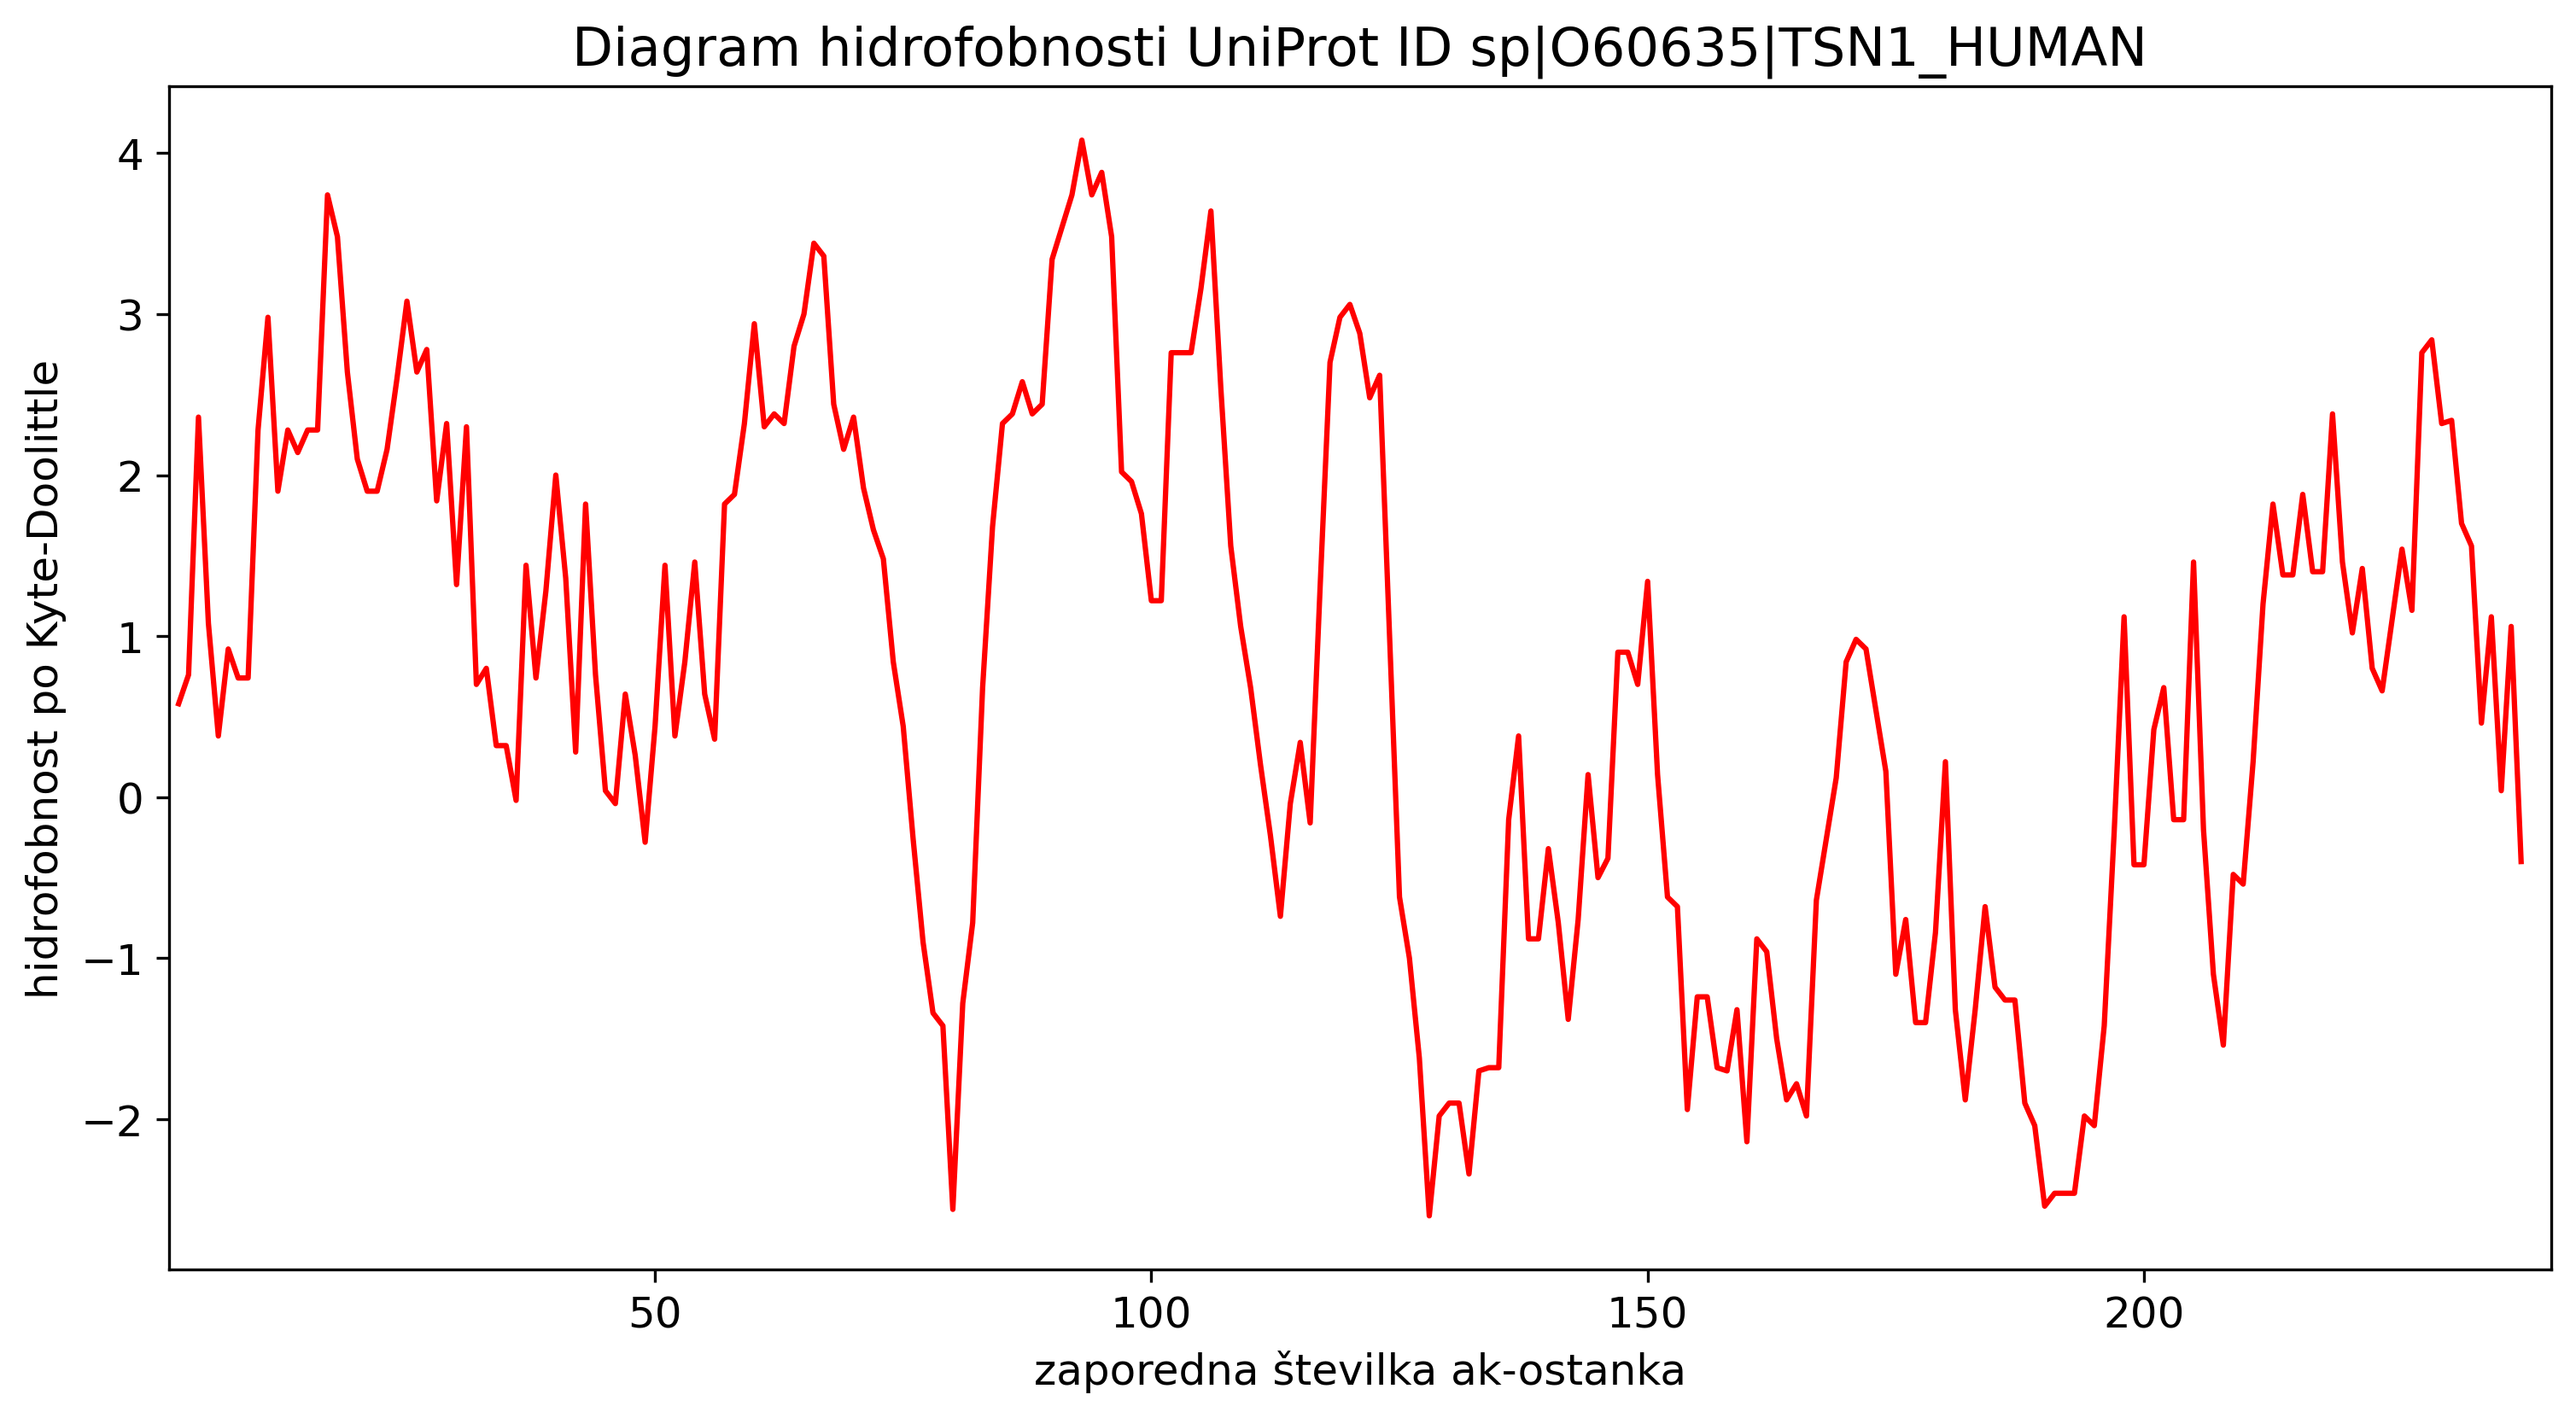

In [17]:
plt.plot(x_data, y_data, 'r')
plt.xlim((1, num_residues))
plt.title('Diagram hidrofobnosti UniProt ID %s' %seq_record.id)   # naslov diagrama
plt.xlabel('zaporedna številka ak-ostanka')   # naslov x-osi
plt.ylabel('hidrofobnost po Kyte-Doolittle')   # naslov y-osi
plt.savefig('izhod/uniprot-hidrofobnost-okno_%d.png' %window_size, bbox_inches='tight')   # sliko shranimo v datoteko
plt.show()   # sliko prikažemo

---
## Naloga

Vaša naloga je, da pripravite program, ki vas bo povprašal po naslednjih parametrih (v tem vrstnem redu):
1. kodi zapisa v UniProt;
2. velikosti okna, za katero želite izrisati zaporedje.

Program naj nato izriše hidrofobni diagram glede na lestvico hidrofobnosti Kyte-Doolittle in sicer za velikost okna, ki ste ga vpisali. Kot v zgledu se naj hidrofobni diagram izriše v zvezku ter tudi shrani kot slikovna datoteka. 

Nato naredite še to:
1. Poizkusite ugotoviti, koliko transmembranskih vijačnic protein, za katerega ste izrisali hidrofobni diagram, vsebuje, ter to primerjajte z zapisov v zbirko UniProt.
2. Poizkusite generirati diagram hidrofobnosti za okna različne velikosti in primerjajte, kako izgledajo. Predvsem se osredotočite na najprimernejšo velikost okna za napoved transmembranskih vijačnic ter zmanjšanje šuma.
3. V razmislek: Lahko takšno napoved uporabimo za napoved proteinov s transmembranskimi $\beta$-ploskvami kot so $\beta$-sodčki, na primer porinov? Primer porina: [UniProt P22340](https://www.uniprot.org/uniprot/P22340).

*Priporočam, da kode v zgledu ne spreminjate temveč si jo skopirate nekje tukaj spodaj ali v nov zvezek, tako da ohranite delujočo kodo za morebitni troubleshooting. Prav tako spremenite imena izhodnih datotek, ki jih program kreira.*


### Dodatna naloga "za entuzijaste"

Podobno kot pri osnovni nalogi pripravite program, ki (v tem vrstnem redu):
1. vpraša za kodo zapisa v UniProt;
2. izpiše, ali je na voljo več izooblik; če jih ni naj program izpiše, da je na voljo samo ena izooblika, če pa jih je več jih naj izpiše ter vpraša, katero želite analizirati;
3. vpraša, ali želite hidrofobni diagram izrisati za celotno zaporedje ali pa samo za en del, v slednjem primeru pa naj vas vpraša za zaporedno številko začetnega in končnega aminokislinskega ostanka želenega območja;
4. vpraša za velikost okna;
5. izriše diagram hidrofobnosti za vse različne lestvice hidrofobnosti, jih prikaže ter shrani v ustrezno poimenovane datoteke (na slikah naj bo v imenu diagrama zraven kode zapisa vsebovano tudi ime lestvice hidrofobnosti, uporabljene za dotično sliko).

Po želji se lahko igrate in si zamislite drugačen potek...